# Variational Autoencoder

In this assignment, we will build Variational Autoencoder, train it on MNIST dataset, and play with its architecture and hyperparameters.

Variational Autoencoder is a probabilistic model of data based on a continuous mixture of distributions. Here we will apply VAE to binary MNIST images (each pixel is either black or white). To better model binary data we will use a continuous mixture of binomial distributions: $p(x \mid w) = \int p(x \mid t, w) p(t) dt$, where the prior distribution on the latent code $t$ is standard normal $p(t) = \mathcal{N}(0, I)$, but probability that $(i, j)$-th pixel is black equals to $(i, j)$-th output of the decoder neural detwork: $p(x_{ij} \mid t, w) = \text{decoder}(t, w)_{ij}$.

To train this model we would like to the maximize marginal log-likelihood of our dataset $\max_w \log p(X \mid w)$, which is very hard to do computationally. Instead, we try to use EM to maximize the Variational Lower Bound w.r.t. both the original parameters $w$ and variational distribution $q$ which is defined as an encoder neural network with weights $\phi$ taking an input image $x$ and outputs the parameters of the gaussian distribution for $q$. Given $q(t \mid x, \phi)$ we will try to maximize Variational Lower Bound $ \mathcal{L}(w, \phi)$ w.r.t. ${w, \phi}$. 


\begin{align*}
\text{max}_{w, \phi}\mathcal{L}(w, \phi) =&\\
=& \sum_i \mathbb{E}_{q_i} \log \frac{p(x_i\mid t_i, w, \phi)p(t_i)}{q_i(t_i)}\\
=& \sum_i \mathbb{E}_{q_i} \log p(x_i\mid t_i, w, \phi) + 
\mathbb{E}_{q_i}\log \frac{p(t_i)}{q_i(t_i)}
\end{align*}

The second term is $-\mathcal{KL}(q_i(t_i)\mid\mid p(t_i))$ which acts as reqularizer. Also, $q_i(t_i)$ is an approximate of the true posterior of the latent variable $p(t_i| x_i, w)$. 

$\mathcal{KL}(q_i(t_i)\mid\mid p(t_i))$ can be analytically calculated, and is equal to: 
$$\sum_j\Big(-\log \sigma_j(t_i) + \frac{\sigma_j^2(t_i) + \mu_j^2(t_i) - 1}{2}\Big)$$
where $\mu(t_i)=(\mu_j(t_i))$ and $\sigma(t_i)=(\sigma_j(t_i))$ are the mean and variance vector for the ditribution of latent variable $t_i$.
They are provided by the encoder and therefore, dependent on $\phi$. However, their gradient is easily hangled by a differentiable programming platform such as TensorFlow. 

Let's look at the gradient of first term which depends on $w$ and $\phi$. With respect to $w$, we have 
\begin{align*}
\bigtriangledown_w\;\mathbb{E}_{q_i} \log p(x_i\mid t_i, w) \\
= &\int q(t_i|x_i, \phi)\bigtriangledown_w\log p(x_i\mid t_i, w)dt_i\\
= \,& \mathbb{E}_{q_i}\bigtriangledown_w\log p(x_i\mid t_i, w)\\
\approx& \bigtriangledown_w\log p(x_i\mid \hat t_i, w)
\end{align*}
where $\hat t_i$ should be sampled from the posterior distribution $q(t_i|x_i, \phi)$. Note that $\bigtriangledown_w\log p(x_i\mid \hat t_i, w)$ is an unbiased approximation of the exact expression. Therefore, the gradient w.r.t. $w$ will be applied on $\log p(x_i\mid t_i, w)$ where $t_i$ is sampled.

The gradient with respect to $\phi$ is more complicated but using a reparametrization, it would flow nicely:
\begin{align*}
\bigtriangledown_\phi\;\mathbb{E}_{q_i} \log p(x_i\mid t_i, w)
= & \bigtriangledown_\phi\ \int q(t_i|x_i, \phi)\log p(x_i\mid t_i, w)dt_i\\
\end{align*}
But now both terms inside the integral depend on $\phi$ especially, in a more comlicated way in the case of $\log p(x_i\mid t_i, w)$ because of $t_i$. The trick to simplfy gradient calulations is to consider $t_i = \varepsilon_i\odot s_i + m_i = g(\varepsilon_i, x_i, \phi)$ where $\varepsilon_i \sim  \mathcal{N}(0, I)$ while $\mathcal{N}(m_i, \text{diag}(s^2_i))$ was distribution of $t_i$. Given that, we get
\begin{align*}
\bigtriangledown_\phi\;\mathbb{E}_{q_i} \log p(x_i\mid t_i, w)
= & \bigtriangledown_\phi\;\mathbb{E}_{p(\varepsilon_i)} \log p(x_i\mid g(\varepsilon_i, x_i, \phi), w)
\end{align*}
which is again reduced to the derivative of $\log p(x_i\mid g(\varepsilon_i, x_i, \phi), w)$ with $\varepsilon_i$ sampled from the standard normal distribution. This is necessary to understand how to implement our loss function for training the model.

So overall our model looks as follows: encoder takes an image $x$, produces a distribution over latent codes $q(t \mid x)$ which should approximate the posterior distribution $p(t \mid x)$ (at least after training), samples a point from this distribution $\widehat{t} \sim q(t \mid x, \phi)$, and finally feeds it into a decoder that outputs a distribution over images.

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

In the lecture, we also discussed that variational lower bound has an expected value inside which we are going to approximate with sampling. But it is not trivial since we need to differentiate through this approximation. However, we learned about _reparametrization trick_ which suggests instead of sampling from distribution $\widehat{t} \sim q(t \mid x, \phi)$ sample from a distribution which doesn't depend on any parameters, e.g. standard normal, and then deterministically transform this sample to the desired one: $\varepsilon \sim \mathcal{N}(0, I); ~~\widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon$ as constant.





So let's get started to implement VAE.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

### Loss 

In Expectation-Maximization, Variational Lower Bound VLB which is typically a negative number has to be maximized. For convenience, we will **minimize** the **negated** of VLB (which will be a positive number) instead of maximizing VLB itself. 

To do that, we need a stochastic estimate of VLB: 
$$\text{VLB} = \sum_{i=1}^N \text{VLB}_i \approx \frac{N}{M}\sum_{i_s}^M \text{VLB}_{i_s}$$
where $N$ is the dataset size, $\text{VLB}_i$ is the term of VLB corresponding to the $i$-th object, and $M$ is the mini-batch size. But instead of this stochastic estimate of the full VLB we will use an estimate of the negated VLB normalized by the dataset size, i.e. the function below returns the average across the mini-batch $-\frac{1}{M}\sum_{i_s}^M \text{VLB}_{i_s}$. People usually optimize the normalized version of VLB since it doesn't depend on the dataset - we can write VLB function once and use it for different datasets - the dataset size won't affect the learning rate too much. We define it based in our calculations above. This is our loss function used to train our model.

In [2]:
def vlb_binomial(model, x):
    """Returns the value of negative Variational Lower Bound
       x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
    Returns:
        A scalar tf.Tensor (averaged across the batch), - VLB
    """
    t_mean, t_log_var = model.encoder(x)
    x_decoded_mean = model(x)
        
    vlb = tf.reduce_mean(tf.reduce_sum(x * tf.math.log(x_decoded_mean + 1e-6) +\
            (1-x)*tf.math.log(1-x_decoded_mean + 1e-6), axis=1) +\
            tf.reduce_sum(0.5 * (t_log_var - tf.exp(t_log_var) - tf.math.pow(t_mean, 2.0) + 1.0 ), axis=1))
    
    return -vlb
 

# Encoder - Decoder Net

We need to built our encoder-decoder network. To do this we use the Functional API in TensorFlow, Keras, to implement the layer combined with obeject oriented aproach to wrap the parts into a final model. We choose this approach as we will need to use the structure agian but with minimal modification. I tried my best to do that but there could be an even better way to do this. 

Let's begin with making a Keras layer from our *sampling* function:

In [3]:
class Sampling(layers.Layer):
  """Uses (t_mean, t_log_var) to sample t."""

  def call(self, inputs):
    t_mean, t_log_var = inputs
    eps = tf.random.normal(shape=tf.shape(t_mean), mean=0.0, stddev=1.0, 
                       dtype=tf.float32, seed=None, name="eps")
    t = t_mean + eps * tf.exp(t_log_var * 0.5)
    return t

We now create our encoder and decoder model using Functional API defind as functions so we can reuse them later easily.

In [5]:
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 10


def create_encoder(input_dim):
    """Create encoder model"""
    
    original_inputs = layers.Input(shape=(input_dim,), name='encoder_input')
    x = layers.Dense(intermediate_dim, activation='relu')(original_inputs)
    t_mean = layers.Dense(latent_dim, name='t_mean')(x)
    t_log_var = layers.Dense(latent_dim, name='t_log_var')(x)
    encoder = tf.keras.Model(inputs=original_inputs, 
                             outputs=[t_mean, t_log_var], 
                             name='encoder')
    return encoder

encoder = create_encoder(original_dim)

# Define decoder model.
def create_decoder(input_dim):
    latent_inputs = layers.Input(shape=(input_dim,), name='decoder_input')
    x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = layers.Dense(original_dim, activation='sigmoid')(x)
    decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
    return decoder

decoder = create_decoder(latent_dim)

We now wrap around our encoder and decoder into the final model:

In [6]:
class VAE(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, name='autoencoder', **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        t = self.encoder(inputs)
        t = Sampling()(t)
        x_decoded_mean = self.decoder(t) 
        return x_decoded_mean

Create an instance of the model to be trained:

In [7]:
vae = VAE()

## Training the model

Now we pass the loss function defined above to GradientTape() API for its gradient to be calculated: 

In [8]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, name='RMSprop')

def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = vlb_binomial(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#### Load and prepare the data

Let's load the MNIST data. Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We normalized the data to be between 0-1. We categorize the labels in one-hot encoding format which will be use later for the second model. We do not need it for VAE model as we are beuilding a generative model. 

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# One hot encoding.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = tf.reshape(x_train, (len(x_train), np.prod(x_train.shape[1:])))
x_test = tf.reshape(x_test, (len(x_test), np.prod(x_test.shape[1:])))



#### Train the model

In [10]:
epochs = 50

for epoch in range(1, epochs + 1):
    for i in range(1, batch_size + 1):
        X_batch = x_train[(i-1)*batch_size:i*batch_size]
        compute_apply_gradients(vae, X_batch, optimizer)
    print('Epoch %d/%d: \n\t loss:%f  - test_loss:%f'%(epoch, epochs,
                                          tf.keras.backend.eval(vlb_binomial(vae, X_batch)),
                                          tf.keras.backend.eval(vlb_binomial(vae, x_test))))

Epoch 1/50: 
	 loss:175.447388  - test_loss:177.718811
Epoch 2/50: 
	 loss:152.781494  - test_loss:155.871414
Epoch 3/50: 
	 loss:141.218445  - test_loss:144.824203
Epoch 4/50: 
	 loss:136.864166  - test_loss:140.452255
Epoch 5/50: 
	 loss:132.582336  - test_loss:136.134689
Epoch 6/50: 
	 loss:130.714478  - test_loss:133.520386
Epoch 7/50: 
	 loss:127.365471  - test_loss:131.078354
Epoch 8/50: 
	 loss:124.928581  - test_loss:128.928650
Epoch 9/50: 
	 loss:123.565338  - test_loss:128.057953
Epoch 10/50: 
	 loss:122.736526  - test_loss:126.555359
Epoch 11/50: 
	 loss:121.068565  - test_loss:125.580147
Epoch 12/50: 
	 loss:119.724541  - test_loss:125.034653
Epoch 13/50: 
	 loss:119.270515  - test_loss:124.073685
Epoch 14/50: 
	 loss:119.398224  - test_loss:123.345177
Epoch 15/50: 
	 loss:117.495422  - test_loss:122.260048
Epoch 16/50: 
	 loss:116.974617  - test_loss:121.729927
Epoch 17/50: 
	 loss:115.241547  - test_loss:121.238647
Epoch 18/50: 
	 loss:115.650627  - test_loss:121.164726
E

In [11]:
vae.save_weights('./checkpoints/my_checkpoint')

### Visualize reconstructions for train and validation data
In the picture below the reconstruction ability of the network is shown on training and validation data. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images).


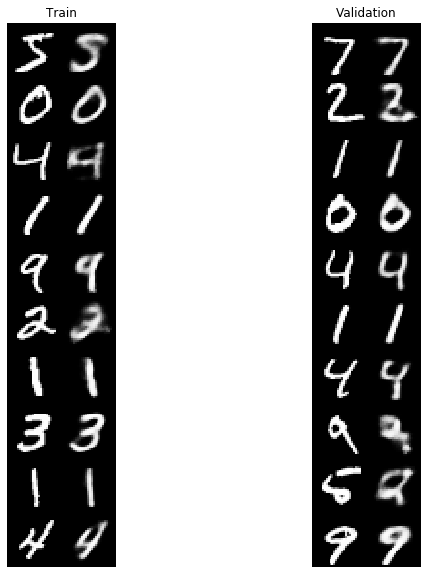

In [12]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = tf.keras.backend.eval(vae(data[:batch_size, :]))
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = tf.keras.backend.eval(tf.reshape(data[i, :], (digit_size, digit_size)))
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Hallucinating new data
In the following cell, new sample images are generated from your trained VAE. To do that we sample from the prior distribution $p(t)$ (standard normal) and then from the likelihood $p(x \mid t)$, which is the output of the decoder.

In [13]:
n_samples = 10 

t_sample = tf.keras.backend.random_normal([n_samples,latent_dim],mean=0.0,stddev=1.0,dtype=tf.float32,seed=12)

sampled_im_mean = tf.keras.backend.eval(vae.decoder(t_sample))

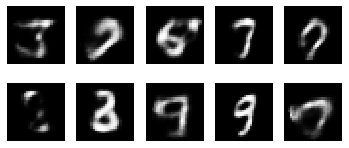

In [14]:
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(tf.reshape(sampled_im_mean[i, :], [28, 28]), cmap='gray')
    ax.axis('off')
plt.show()

# Conditional VAE

We can easily modify the above code to obtain Conditional Variational Autoencoder [1]. The idea is very simple: we can pass more information about the samples to the model that makes it easier for the model to generate more accurate samples. To do this, we condition all the distributions on some additional information. In our case, this additional information could be the class label (the digit on the image, from 0 to 9).

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

So now both the likelihood and the variational distributions are conditioned on the class label: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi)$.

The only thing we need to do in your code is to concatenate input image $x$ with (one-hot) label of this image to pass into the encoder $q$ and to concatenate latent code $t$ with the same label to pass into the decoder $p$. This is slightly harder to do with convolutional encoder/decoder model.

This change would definitely imporove the model as we are giving more information about the type of a sample to the model. 

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

We can easily reuse the code for encoder-decoder but need a slight mod for the model to take the concatenation of the images and their labels as input.

In [15]:
encoder = create_encoder(original_dim + 10)
decoder = create_decoder(latent_dim + 10)

And, the conditional variational autoencoder model:

In [18]:
class CVAE(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, name='autoencoder', **kwargs):
        super(CVAE, self).__init__(name=name, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        x, labels = inputs
        t = layers.concatenate([x, labels], axis=1)
        t = self.encoder(t)
        t = Sampling()(t)
        t = layers.concatenate([t, labels], axis=1)
        x_decoded_mean = self.decoder(t)
        return x_decoded_mean

In [19]:
cvae = CVAE()

We add a one-line code to the loss function:

In [20]:
def cvlb_binomial(model, x):
    
    y = tf.keras.backend.concatenate(x, axis=1)
    t_mean, t_log_var = model.encoder(y)
    x_decoded_mean = model(x)
        
    vlb = tf.reduce_mean(tf.reduce_sum(x[0] * tf.math.log(x_decoded_mean + 1e-6) +\
            (1-x[0])*tf.math.log(1-x_decoded_mean + 1e-6), axis=1) +\
            tf.reduce_sum(0.5 * (t_log_var - tf.exp(t_log_var) - tf.math.pow(t_mean, 2.0) + 1.0 ), axis=1))
    
    return -vlb
 

In [21]:
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = cvlb_binomial(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [24]:
epochs = 50

for epoch in range(1, epochs + 1):
    for i in range(1, batch_size + 1):
        X_batch = x_train[(i-1)*batch_size:i*batch_size]
        y_batch = y_train[(i-1)*batch_size:i*batch_size]
        compute_apply_gradients(cvae, [X_batch, y_batch], optimizer)
    print('Epoch %d/%d: \n\t loss:%f  - test_loss:%f'%(epoch, epochs,
          tf.keras.backend.eval(cvlb_binomial(cvae,[X_batch, y_batch])),
          tf.keras.backend.eval(cvlb_binomial(cvae,[x_test, y_test]))))

Epoch 1/50: 
	 loss:133.675583  - test_loss:136.307495
Epoch 2/50: 
	 loss:127.877884  - test_loss:132.039337
Epoch 3/50: 
	 loss:125.633469  - test_loss:129.899368
Epoch 4/50: 
	 loss:122.403328  - test_loss:127.043228
Epoch 5/50: 
	 loss:121.324707  - test_loss:125.626816
Epoch 6/50: 
	 loss:119.545937  - test_loss:125.114059
Epoch 7/50: 
	 loss:118.103584  - test_loss:122.498489
Epoch 8/50: 
	 loss:116.838661  - test_loss:121.197075
Epoch 9/50: 
	 loss:116.612625  - test_loss:121.929649
Epoch 10/50: 
	 loss:116.329895  - test_loss:120.733948
Epoch 11/50: 
	 loss:114.462463  - test_loss:119.896912
Epoch 12/50: 
	 loss:114.239326  - test_loss:118.669472
Epoch 13/50: 
	 loss:112.326385  - test_loss:118.256363
Epoch 14/50: 
	 loss:112.066261  - test_loss:117.546761
Epoch 15/50: 
	 loss:111.633415  - test_loss:116.976372
Epoch 16/50: 
	 loss:111.464806  - test_loss:116.348213
Epoch 17/50: 
	 loss:110.365829  - test_loss:116.336975
Epoch 18/50: 
	 loss:110.012962  - test_loss:115.358528
E

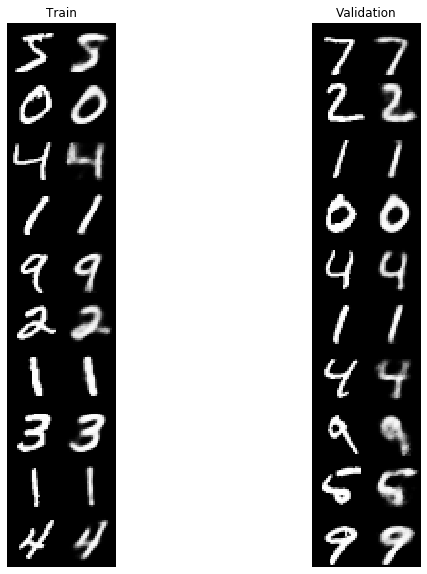

In [26]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = tf.keras.backend.eval(cvae([x_data[:batch_size, :], 
                                     y_data[:batch_size, :]]))
    
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = tf.keras.backend.eval(tf.reshape(x_data[i, :],(digit_size, digit_size)))
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [27]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.

curr_labels = tf.convert_to_tensor(curr_labels, dtype=tf.float32)

t_sample = tf.keras.backend.random_normal([50,latent_dim], mean=0.0, stddev=1.0, dtype=tf.float32, seed=12)
t = layers.concatenate([t_sample, curr_labels], axis=1)

cond_sampled_im_mean = tf.keras.backend.eval(cvae.decoder(t))

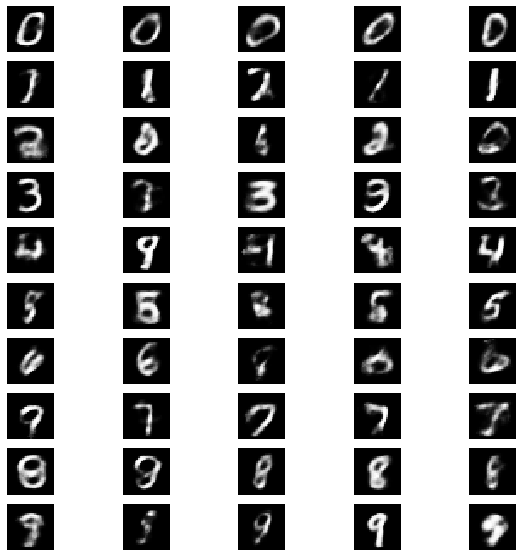

In [28]:
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()

Another way of extension for this work is to modify the code such that it works with the mixture of Gaussian distributions (in contrast to the mixture of Binomial distributions). This allows us to mimic the above experience for full color natural images with more diverse structures such as the ones in CIFAR-10 dataset.
Finally, there are better generative model such as GAN for images but the significance of variational autoencoder is not limited to its generative model for images.